In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import pickle

%load_ext autoreload
%autoreload 3

### Load CM2

In [2]:
def sort_longitude(x):
    x['lon'] = np.where(x['lon']>0, x['lon'], 360+x['lon'])
    x = x.sortby('lon')
    return x

In [100]:
''' Combine atmosphere and ocean 
    atm has 576 * 360 grid
    ocn has 3600 * 2700 grid ''' 

# atm = xr.open_dataset('../data/Global/GFDL_CM2p6_control_atm_0101.nc', chunks={})
# atm['t_ref'] = atm['t_ref'] - 273.15

# ocn = xr.open_dataset('../data/Global/GFDL_CM2p6_control_ocn_0101.nc', chunks={})
# ocn = ocn.isel(time=0)

# ocn = ocn.rename({'xt_ocean': 'lon', 'yt_ocean': 'lat'})
# ocn = sort_longitude(ocn)
# atm['sst'] = ocn.surface_temp.interp(lon=atm['grid_xt'],lat=atm['grid_yt'])
# ocn = ocn.rename({'lon': 'xt_ocean', 'lat': 'yt_ocean'})

# ocn = ocn.rename({'xu_ocean': 'lon', 'yu_ocean': 'lat'})
# ocn = sort_longitude(ocn)
# atm['usurf'] = ocn.usurf.interp(lon=atm['grid_xt'],lat=atm['grid_yt'])
# atm['vsurf'] = ocn.vsurf.interp(lon=atm['grid_xt'],lat=atm['grid_yt'])
# ocn = ocn.rename({'lon': 'xu_ocean', 'lat': 'yu_ocean'})

# atm.to_netcdf('../data/Global/GFDL_CM2p6_combined_20200101.nc')

''' Only need to read in combined '''
ds = xr.open_dataset('../data/Global/GFDL_CM2p6_combined_20200101.nc')

#### Visualization of fields

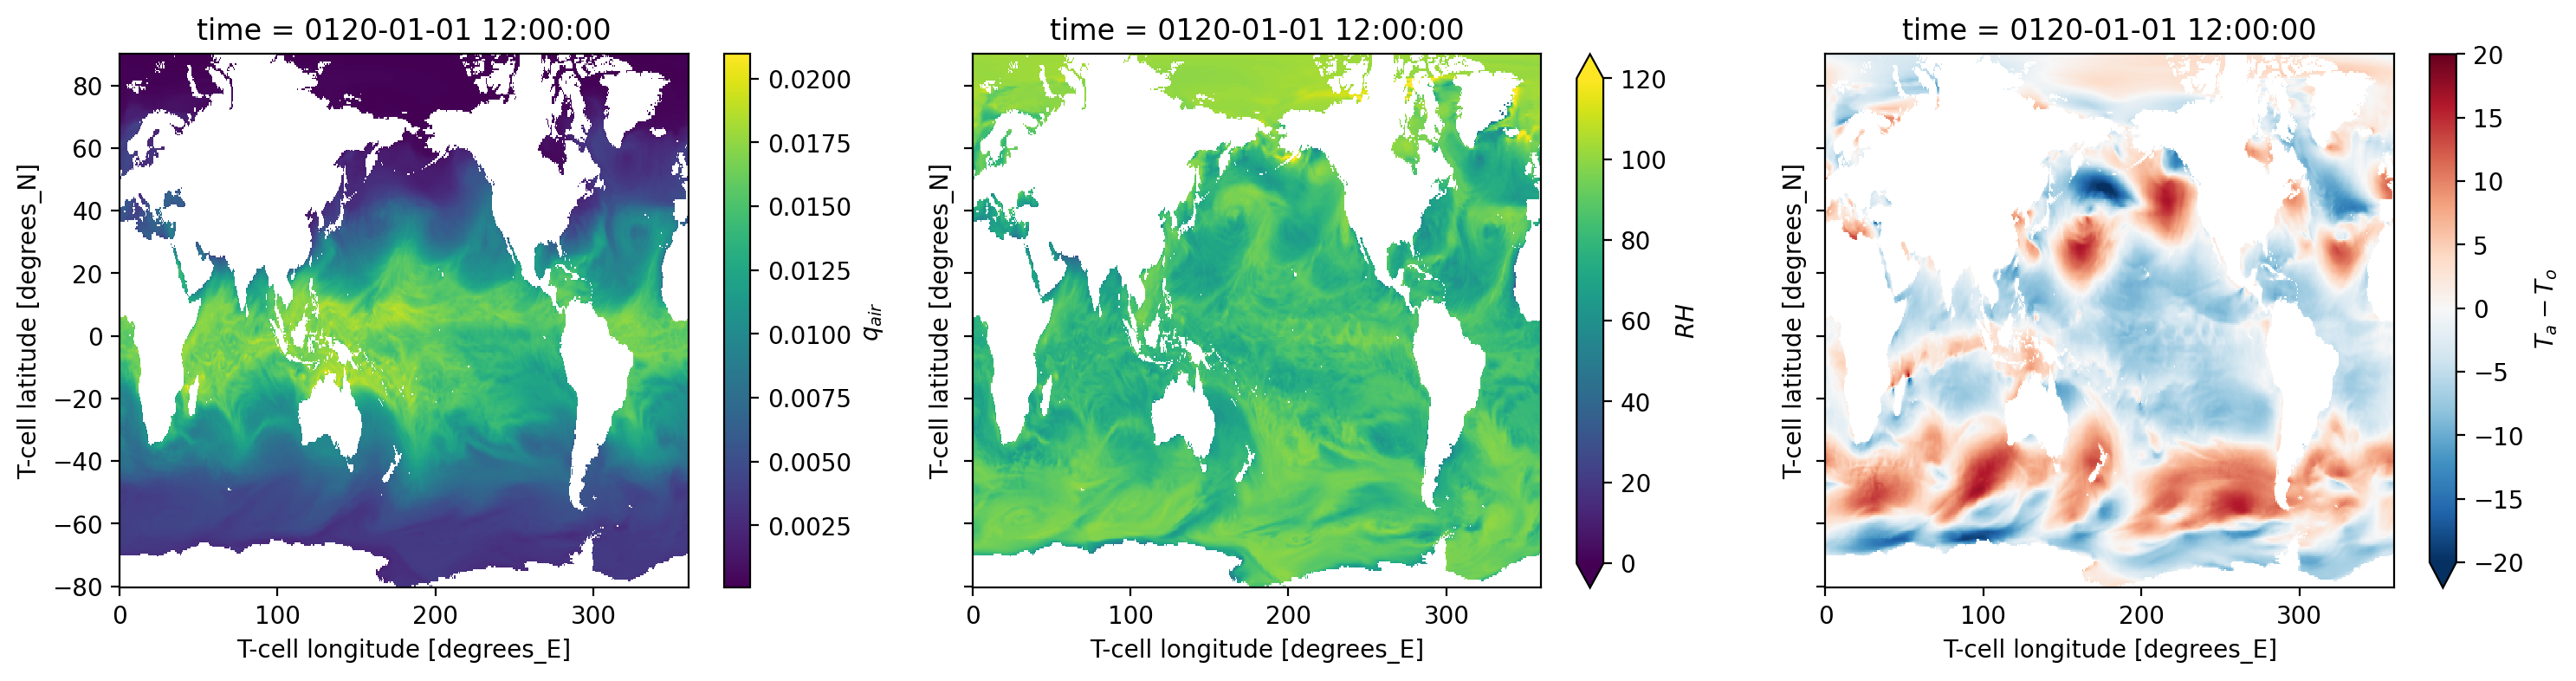

In [133]:
''' Visualize some fields '''
fig, axes = plt.subplots(1,3, figsize=[18,4], dpi=200, sharey=True)

# Wet mask
mask = ~np.isnan(ds.sst)
ds_dropna = ds.where(mask.compute(), drop=True)

# Absolute humidity
ds_dropna.q_ref.plot(ax=axes[0], cbar_kwargs={'label':'$q_{air}$'})

# Relative humidity
ds_dropna.rh_ref.plot(ax=axes[1], vmax=0, vmin=120, cbar_kwargs={'label':'$RH$'})

# Air temperature - SST
# (ds_dropna.t_ref - ds_dropna.sst).plot(ax=axes[1], cmap='RdBu_r', vmax=5, vmin=-5,cbar_kwargs={'label':r'$T_a - T_o$'})

# Air temperature
# ds.t_ref.plot(ax=axes[2], cbar_kwargs={'label':r'$T_{air}$'})

# Wind
ds_dropna.u_ref.plot(ax=axes[2], cmap='RdBu_r', vmax=20, vmin=-20, cbar_kwargs={'label':r'$T_a - T_o$'})

plt.show()

#### Visualization of state variable distribution

Total points: 207360. Wet points: 196416


/ext3/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/ext3/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


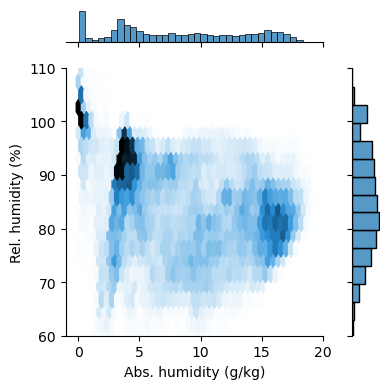

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt

# wet mask
mask = ~np.isnan(ds.sst)
ds_dropna = ds.where(mask.compute(), drop=True)
q = ds_dropna.q_ref.values.flatten()*1000
rh = ds_dropna.rh_ref.values.flatten()
print('Total points: %g. Wet points: %g' %(len(ds.q_ref.values.flatten()), len(q)))

d = {'q': q, 'rh': rh}
df = pd.DataFrame(data=d)
 
# Custom the inside plot: options are: “scatter” | “reg” | “resid” | “kde” | “hex”
# g = sns.jointplot(x=q[::1], y=rh[::1], kind='kde', xlim=[-5,20],
#               ylim=[40,120], fill=True, height=4)
g = sns.jointplot(x=q[::1], y=rh[::1], kind='hex', xlim=[-1,20],
              ylim=[60,110], height=4, marginal_kws=dict(bins=40, fill=True), vmin=0, vmax=1000)
plt.gcf().set_dpi(100)

plt.xlabel('Abs. humidity (g/kg)'); plt.ylabel('Rel. humidity (%)')
plt.tight_layout()
plt.show()

### Load ANNs and make predictions

In [48]:
''' Predictor with four inputs and four outputs, and with fixed first layer taking temperature difference. '''
from mlflux.ann import ANNdiff   
from mlflux.predictor import FluxANNs
class Fluxdiff(FluxANNs):
    def __init__(self,params={}):
        super().__init__(params)
        self.mean_func = ANNdiff(**self.mean_ann_para)
        self.var_func = ANNdiff(**self.var_ann_para)  

In [75]:
# i = 5
# filename = "../saved_model/full_anns_diff_momentum_3layers_split%g.p" %(i+1)
# with open(filename, "rb") as input_file:
#     model = pickle.load(input_file)

i = 0
filename = "../saved_model/full_anns_diff_sensible_3layers_split%g.p" %(i+1)
with open(filename, "rb") as input_file:
    model = pickle.load(input_file)

In [76]:
# keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['taucx'], 'bkeys':['taubx']}
import torch
input_keys = ['wind','sst','t_ref','rh_ref']
# output_keys = ['wind','sst','t_ref','rh']
X = torch.tensor(np.hstack([atm[key].values.reshape(-1,1) for key in input_keys]).astype('float32'))
Y = model.pred_mean(X).detach().numpy()
# error = model.pred_mean(vd.X).detach().numpy() - vd.Y.detach().numpy()

In [77]:
atm['Qs'] = (['grid_yt', 'grid_xt'], Y.reshape(-1,576)) 

Text(0.5, 1.0, 'Sensible heat flux')

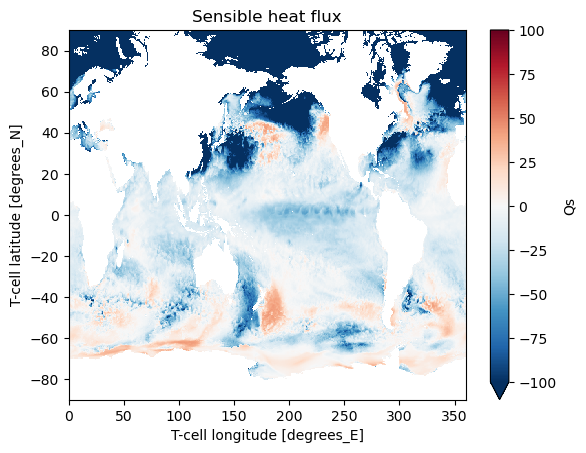

In [78]:
atm['Qs'].plot(vmax=100, vmin=-100, cmap='RdBu_r')
plt.title('Sensible heat flux')

In [96]:
input_keys = ['wind','sst','t_ref','rh_ref']

X = torch.tensor(np.hstack([atm[key].values.reshape(-1,1) for key in input_keys]).astype('float32'))
Y_ensem = []
for i in range(0,6):
    filename = "../saved_model/full_anns_diff_latent_3layers_split%g.p" %(i+1)
    with open(filename, "rb") as input_file:
        model = pickle.load(input_file)
        Y = model.pred_mean(X).detach().numpy()
        Y_ensem.append(Y)

Y_mean = np.average(np.array(Y_ensem), axis=0)
Y_std = np.std(np.array(Y_ensem), axis=0)

In [84]:
atm['Qs_mean'] = (['grid_yt', 'grid_xt'], Y_mean.reshape(-1,576)) 
atm['Qs_std'] = (['grid_yt', 'grid_xt'], Y_std.reshape(-1,576)) 

Text(0.5, 1.0, 'Sensible heat flux mean (from ANN ensem size 6)')

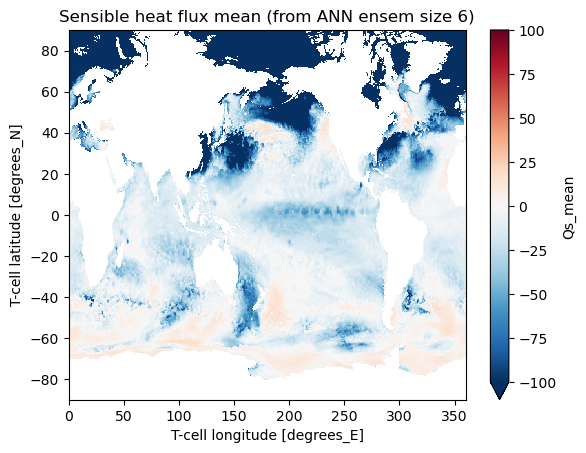

In [94]:
atm['Qs_mean'].plot(vmax=100, vmin=-100, cmap='RdBu_r')
plt.title('Sensible heat flux mean (from ANN ensem size 6)')

Text(0.5, 1.0, 'Sensible heat flux std (from ANN ensem size 6)')

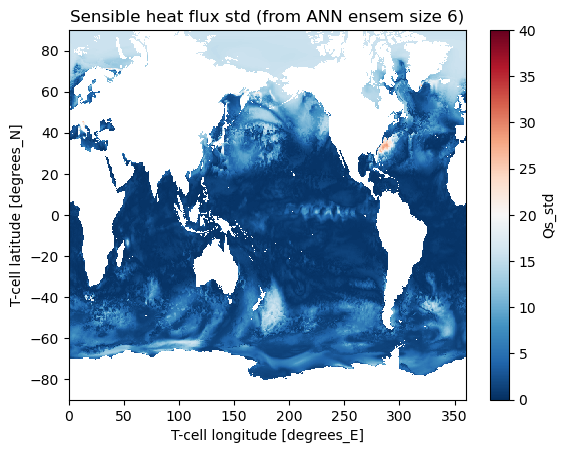

In [95]:
atm['Qs_std'].plot(vmax=40, vmin=0, cmap='RdBu_r')
plt.title('Sensible heat flux std (from ANN ensem size 6)')

In [97]:
input_keys = ['wind','sst','t_ref','rh_ref']

X = torch.tensor(np.hstack([atm[key].values.reshape(-1,1) for key in input_keys]).astype('float32'))
Y_ensem = []
for i in range(0,6):
    filename = "../saved_model/full_anns_diff_latent_3layers_split%g.p" %(i+1)
    with open(filename, "rb") as input_file:
        model = pickle.load(input_file)
        Y = model.pred_mean(X).detach().numpy()
        Y_ensem.append(Y)

Y_mean = np.average(np.array(Y_ensem), axis=0)
Y_std = np.std(np.array(Y_ensem), axis=0)

atm['Ql_mean'] = (['grid_yt', 'grid_xt'], Y_mean.reshape(-1,576)) 
atm['Ql_std'] = (['grid_yt', 'grid_xt'], Y_std.reshape(-1,576)) 

Text(0.5, 1.0, 'Latent heat flux mean (from ANN ensem size 6)')

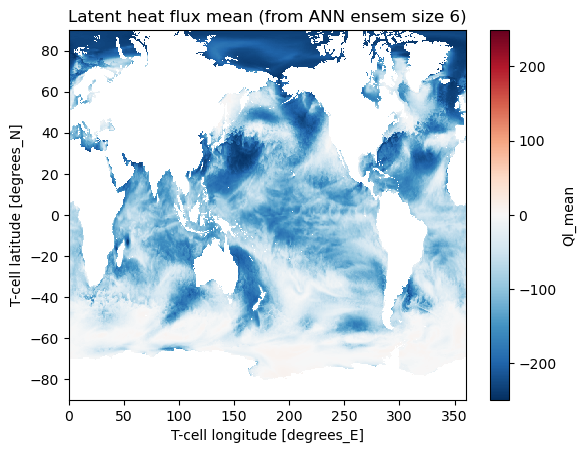

In [111]:
atm['Ql_mean'].plot()
plt.title('Latent heat flux mean (from ANN ensem size 6)')

Text(0.5, 1.0, 'Latent heat flux std (from ANN ensem size 6)')

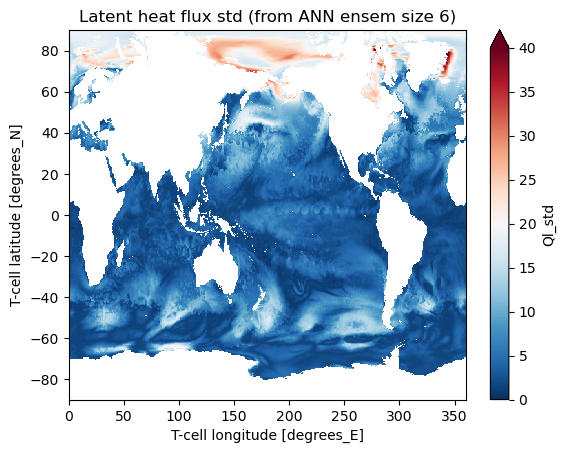

In [112]:
atm['Ql_std'].plot(vmax=40, vmin=0, cmap='RdBu_r')
plt.title('Latent heat flux std (from ANN ensem size 6)')

In [117]:
input_keys = ['wind','sst','t_ref','rh_ref']

X = torch.tensor(np.hstack([atm[key].values.reshape(-1,1) for key in input_keys]).astype('float32'))
Y_ensem = []
for i in range(0,6):
    filename = "../saved_model/full_anns_diff_momentum_3layers_split%g.p" %(i+1)
    with open(filename, "rb") as input_file:
        model = pickle.load(input_file)
        Y = model.pred_mean(X).detach().numpy()
        Y_ensem.append(Y)

Y_mean = np.average(np.array(Y_ensem), axis=0)
Y_std = np.std(np.array(Y_ensem), axis=0)

atm['tau_mean'] = (['grid_yt', 'grid_xt'], Y_mean.reshape(-1,576)) 
atm['tau_std'] = (['grid_yt', 'grid_xt'], Y_std.reshape(-1,576)) 

Text(0.5, 1.0, 'Momentum flux mean (from ANN ensem size 6)')

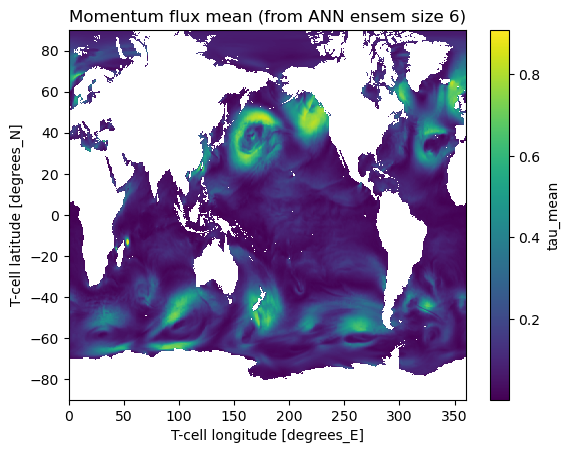

In [115]:
atm['tau_mean'].plot()
plt.title('Momentum flux mean (from ANN ensem size 6)')

Text(0.5, 1.0, 'Momentum flux std (from ANN ensem size 6)')

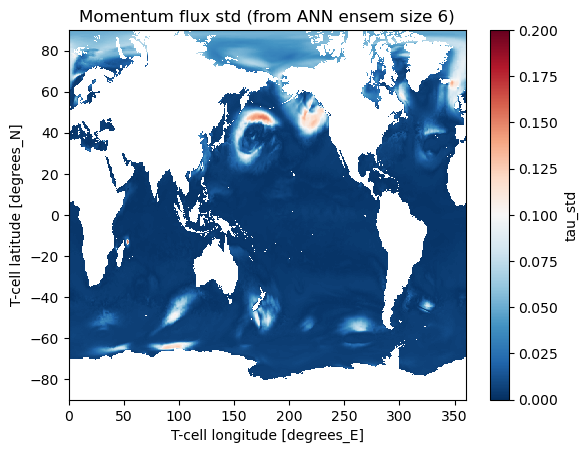

In [120]:
atm['tau_std'].plot(vmax=0.2, vmin=0, cmap='RdBu_r')
plt.title('Momentum flux std (from ANN ensem size 6)')

### Older code

In [ ]:
''' This is when the atmosphere is from ERA and there is no RH. 
    Not needed for CM2 since there is already humidity. 
'''

from mlflux.utils import qsat
def rhcalc(t,p,q):
    ''' Copied from utils.py with ad hoc constant pressure
    '''
    es = qsat(t,p)
    em = p * q / (0.622 + 0.378 * q)
    rh = 100.0 * em / es
    return rh

# Test
print(rhcalc(0, 910, 0.005))

# Compute wind speed or now dis-regard current
# ocn['U'] = (ocn['atm_u']**2 + ocn['atm_v']**2)**0.5
# ocn['U'].plot(vmin=0, vmax=25)

# Compute relative humidity
ocn['atm_p'] = xr.ones_like(ocn['atm_temp']) * 1010
ocn['rh'] = xr.apply_ufunc(
        rhcalc,
        ocn.atm_temp.load(),
        ocn.atm_p.load(), # pressure in millibar, instead of pascal (1 millibar = 100 pascals)
        ocn.atm_q.load(), # already in kg/kg
        input_core_dims=[()] * 3,
        output_core_dims=[()] * 1,
        #dask="parallelized",
        #output_dtypes=[ocn.atm_temp] * 1,  # deactivates the 1 element check which aerobulk does not like
)

ocn['rh'].plot(vmax=100)